[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/03.regression_contd-and-classification/c.classification.ipynb)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [8]:
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
import sys
sys.path.append("..")
from Module.visualization import plot_conf_mat

In [9]:
savefigures=False

Download the dataset from my github

In [10]:
dataset_to_use = 'A'
mydatasets_folder = "../Data/"
filename = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
complete_name = mydatasets_folder+filename


In [12]:
df = pd.read_csv(complete_name)

In [14]:
print("The resolutions found in our dataset are")
set(df['Diabetes_binary'].values)

The resolutions found in our dataset are


{np.float64(0.0), np.float64(1.0)}

How many samples in each class?

In [15]:
df['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64

# Binary classification with Logistic Regression

We want to infer whether the diabete (1 he/she have it)

In [18]:
high_res = df['Diabetes_binary']==1
high_res.head()

0    False
1    False
2    False
3    False
4    False
Name: Diabetes_binary, dtype: bool

Convert into `int`

In [20]:
df['high_res'] = high_res

In [21]:
df_train,df_test = train_test_split(df, test_size=0.2, random_state=1)

columns = ['GenHlth', 'PhysHlth']

X_train = df_train[columns]
X_test = df_test[columns]
y_train = df_train['high_res']
y_test = df_test['high_res']

Logistic regression adds by default a regularization with weight `C`.
Let's try with no regularization first

In [22]:
# We cannot directly write `C=0`, as the library wants `C`>0, so we just provide a very small `C`

model = LogisticRegression(C=1e-9)
model.fit(X_train, y_train)

LogisticRegression(C=1e-09)

In [23]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.49883008, 0.50116992],
       [0.49882369, 0.50117631],
       [0.49882688, 0.50117312],
       ...,
       [0.49882369, 0.50117631],
       [0.49882369, 0.50117631],
       [0.49882688, 0.50117312]], shape=(14139, 2))

`y_pred_proba` has two values:
* $\mathbb{P}(\mathbf{x}\notin \text{class }1)$
* $\mathbb{P}(\mathbf{x}\in \text{class }1)$

They sum up to 1.

The actual prediction is

In [24]:
y_pred = model.predict(X_test)
y_pred

array([ True,  True,  True, ...,  True,  True,  True], shape=(14139,))

Let's have a look at the predictions vs. the true value

In [25]:
pd.DataFrame({'true':y_test, 'pred':y_pred })

,true,pred
25002,False,True
45944,True,True
23894,False,True
6931,False,True
39255,True,True
...,...,...
49773,True,True
4164,False,True
11688,False,True
47518,True,True


Let's evaluate the goodness of our classifier

In [26]:
accuracy_score(y_test, y_pred)

0.49494306528043003

### Normalization

Very bad. Our classifier is just a random guess!

Let' first normalize. Normalization is important every time you use a sigmoid (as in Logistic Regression).

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [28]:
model = LogisticRegression(C=1)
model.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

In [29]:
accuracy_score(y_pred, y_test)

0.6889454699766603

Better.

## Decision boundary

Let's plot our dataset

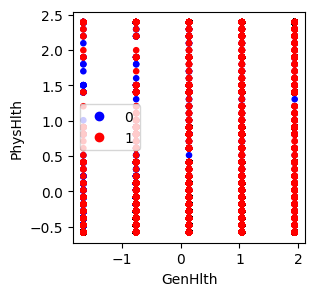

In [30]:
fig, ax = plt.subplots(figsize=(3,3) )

X = df[columns]

X_scaled = scaler.transform(X)

BytesReceived0_scaled = X_scaled[:,0]
PacketsSent0_scaled = X_scaled[:,1]

scatter = ax.scatter(BytesReceived0_scaled, PacketsSent0_scaled,
          c=df['high_res'], cmap='bwr', s=14)


ax.set(xlabel="GenHlth", ylabel="PhysHlth" )

# Add the legend associated to the different colors
legend = ax.legend(*scatter.legend_elements() )

Let's plot the decision boundary, i.e. the surface that separates the regions of the space in which prediction is `1` from the ones in which preciction is `0`.

In [31]:
# This code is not important to understand

### First, create a grid of points
horiz_min = min(BytesReceived0_scaled)
vert_min = min(PacketsSent0_scaled)
horiz_max = max(BytesReceived0_scaled)
vert_max = max(PacketsSent0_scaled)

grid_step=0.1

horiz_part, vert_part = \
    np.mgrid[horiz_min:horiz_max:grid_step,
             vert_min:vert_max:grid_step]
grid = np.c_[horiz_part.ravel(), vert_part.ravel()]
print ("The grid is ", grid)
grid_probability = model.predict_proba(grid)[:,1]
print("The probability associated to each point is", grid_probability)
grid_probability = grid_probability.reshape(horiz_part.shape)
print("After reshaping", grid_probability)

The grid is  [[-1.65110648 -0.58002897]
 [-1.65110648 -0.48002897]
 [-1.65110648 -0.38002897]
 ...
 [ 1.84889352  2.11997103]
 [ 1.84889352  2.21997103]
 [ 1.84889352  2.31997103]]
The probability associated to each point is [0.17499261 0.17448512 0.17397879 ... 0.84725464 0.84679864 0.84634153]
After reshaping [[0.17499261 0.17448512 0.17397879 ... 0.16169529 0.16121882 0.16074349]
 [0.18928234 0.18874289 0.18820462 ... 0.17512967 0.17462186 0.17411522]
 [0.20444978 0.20387797 0.20330735 ... 0.18942801 0.18888824 0.18834965]
 ...
 [0.83428582 0.8337987  0.83331043 ... 0.82072866 0.82021028 0.81969073]
 [0.84713178 0.84667548 0.84621807 ... 0.83441698 0.83393017 0.83344222]
 [0.85915006 0.85872365 0.85829617 ... 0.84725464 0.84679864 0.84634153]]


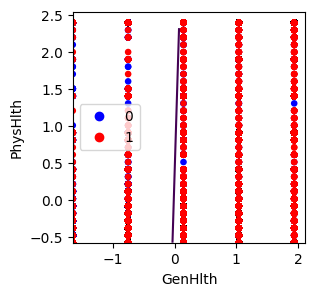

In [32]:
### Now, add to the scatterplot the decision boundaruy

ax.contour(horiz_part, vert_part, grid_probability, [0.5])
fig.set_size_inches(3, 3)
fig


In [33]:
accuracy_score(y_pred, y_test)

0.6889454699766603

Accuracy may be a misleading. To really understand the performance of the classifier, we need to plot a confusion matrix. We will use a function I created for you. Let's check its documentation.

In [41]:
threshold1=0
threshold2=1

res = [0 if d == threshold1
       else 1
      for d in df['Diabetes_binary']
      ]

df['res'] = res

In [42]:
def MyMultinomialRegression(C=1e-9):
    return make_pipeline(
        StandardScaler(),
        LogisticRegression(multi_class="multinomial", solver="lbfgs", C=C)
    )

In [43]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=1)

y_train = df_train['res']
y_test = df_test['res']
y_pred = model.predict(X_test_scaled)
model = MyMultinomialRegression(C=1)
model.fit(X_train, y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, multi_class='multinomial'))])

In [44]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 1, 0], shape=(14139,))

Normalized confusion matrix
[[0.59011343 0.40988657]
 [0.21020292 0.78979708]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

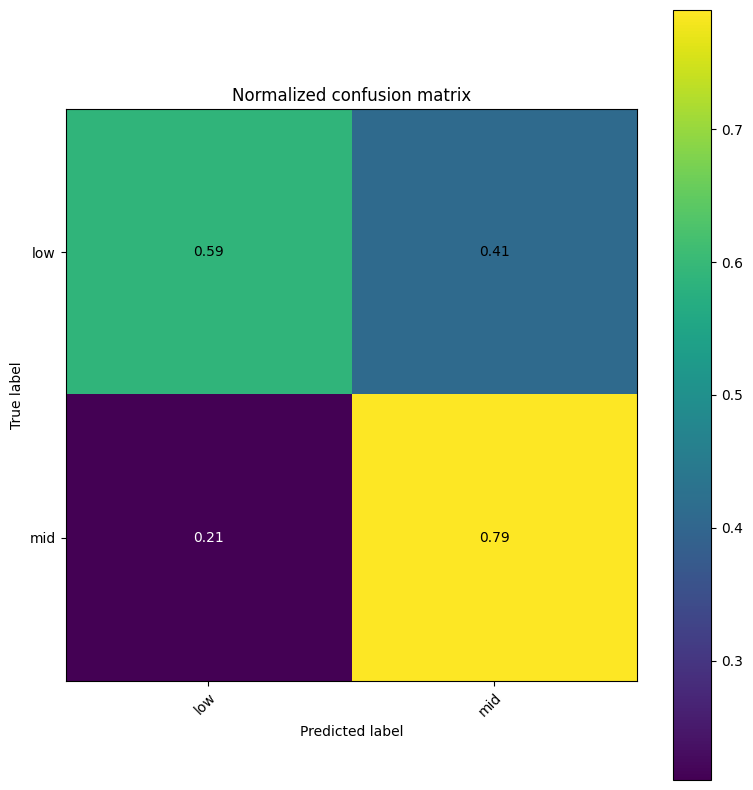

In [45]:
class_names=np.array(["low", "mid", "high"] )

plot_conf_mat(y_test, y_pred, class_names)

You can customize the confusion matrix more. For instance you may change the size. If you have many labels, you may need to remove numbers printed.

Confusion matrix, without normalization
[[4214 2927]
 [1471 5527]]


<Axes: title={'center': 'My beautiful confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

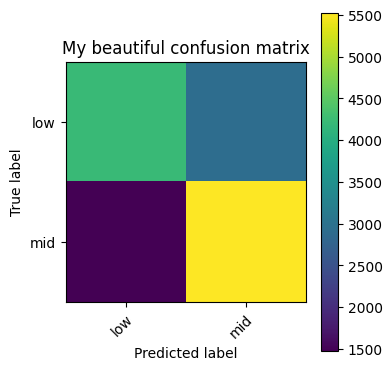

In [46]:
plot_conf_mat(y_test, y_pred, class_names, normalize=False,
              title="My beautiful confusion matrix", cmap=plt.cm.viridis,
              text=False, width=4, height=4)

In [47]:
df['res'].value_counts()

res
0    35346
1    35346
Name: count, dtype: int64

In [51]:
accuracy_score(y_pred, y_test)

0.6889454699766603

Some ideas to improve it further?
<details>
<summary>
CLICK
</summary>
    
* Find the regularization weight via grid search
* Try to transform the input
* Find the best combination of features manually or via Recursive Feature Elimination
    
    
</details>

A classification report summarizes for us all the important features

In [52]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      7141
           1       0.65      0.79      0.72      6998

    accuracy                           0.69     14139
   macro avg       0.70      0.69      0.69     14139
weighted avg       0.70      0.69      0.69     14139



# Grid search

Let's find the best regularization weight `C` via grid search. Let's first check what is the correct name of the parameter `C` to which we need to refer.

In [53]:
GridSearchCV(MyMultinomialRegression(), [] ).get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__transform_input', 'estimator__verbose', 'estimator__standardscaler', 'estimator__logisticregression', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__logisticregression__C', 'estimator__logisticregression__class_weight', 'estimator__logisticregression__dual', 'estimator__logisticregression__fit_intercept', 'estimator__logisticregression__intercept_scaling', 'estimator__logisticregression__l1_ratio', 'estimator__logisticregression__max_iter', 'estimator__logisticregression__multi_class', 'estimator__logisticregression__n_jobs', 'estimator__logisticregression__penalty', 'estimator__logisticregression__random_state', 'estimator__logisticregression__solver', 'estimator__logisticregression__tol', 'estimator__logisticregression__verbose', 'estimator__logisticregression__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatc

In [54]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=5)

parameters_to_test = [{ 'logisticregression__C': [1e-9, 1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000] }]

# The different scoring metrics available are in:
#     https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = GridSearchCV(MyMultinomialRegression(), parameters_to_test, cv=k_fold,
                    scoring='f1_macro')

In [55]:
grid.fit(X_train, y_train)
print("The best regularization weigth is ", grid.best_params_)

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, bin

The best regularization weigth is  {'logisticregression__C': 0.001}


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, bin

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      7141
           1       0.65      0.79      0.72      6998

    accuracy                           0.69     14139
   macro avg       0.70      0.69      0.69     14139
weighted avg       0.70      0.69      0.69     14139

Normalized confusion matrix
[[0.59011343 0.40988657]
 [0.21020292 0.78979708]]


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

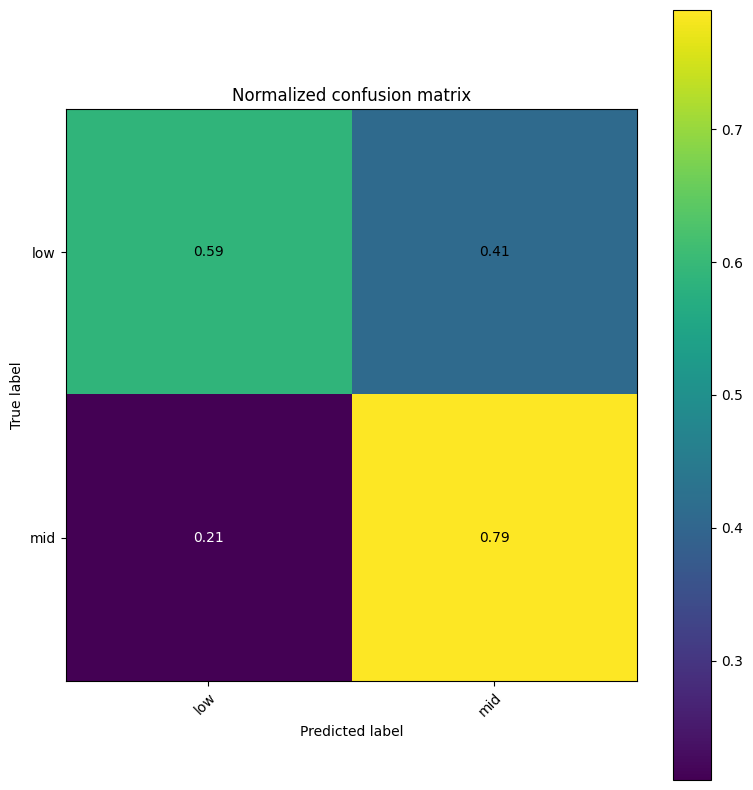

In [56]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_conf_mat(y_test, y_pred, class_names)

Some ideas to improve this model?
<details>
<summary>
CLICK
</summary>
    
* Since data are "squashed" towards low value => log-transformation
* Find the best combination of features manually or via Recursive Feature Elimination
    
    
</details>